In [2]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf

OmegaConf.register_new_resolver(
    "relpath", lambda p: str(Path('/disk/scratch2/nkudryas/BAND-torch/notebooks/').parent / p)
)

import os
os.environ["CUDA_VISIBLE_DEVICES"]= "6"

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import h5py
from sklearn.linear_model import Ridge 
from sklearn.decomposition import PCA

from lfads_torch.metrics import r2_score, r2_UIVE


Matplotlib created a temporary cache directory at /tmp/matplotlib-114dgqvg because the default path (/afs/inf.ed.ac.uk/user/n/nkudryas/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
dataset_name = 'chewie_10_07'
# model_str='kl1_gauss_bd05'
model_str='kl1_gauss_bd_d20_causal_ci'
# model_str='kl1_gauss_causal_nosplit'

bin_size_ms = 10

N_FOLDS = 5

In [4]:
models_dest = f"/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/{dataset_name}"

fac_dim, co_dim = 100,4
bw = 0.1
encod_seq_len = 101
encod_data_dim = 207
seed = 2
model_names = [f'{model_name}_both_{fac_dim}f_{co_dim}c_{model_str}' for model_name in ['lfads','band']]
model_dests = [[f"{models_dest}_cv{cv}/{model_name}" for cv in range(N_FOLDS)] for model_name in model_names]

model_dests


[['/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv0/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv1/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv2/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv3/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv4/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci'],
 ['/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv0/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv1/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv2/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  

In [5]:
# model_dests[0][-1] = '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv4/lfads_both_8f_4c_kl1_gauss_bd'
# model_dests[0] = [f"/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/{dataset_name}_cv{cv}/lfads_both_8f_4c_kl1_gauss_bd05" for cv in range(N_FOLDS)]
model_dests

[['/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv0/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv1/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv2/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv3/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv4/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci'],
 ['/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv0/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv1/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv2/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  

In [6]:
import torch
from hydra.utils import instantiate
from pathlib import Path
import hydra

from lfads_torch.band_utils import flatten

models = []
for fold in range(N_FOLDS):

    overrides={
            "datamodule": dataset_name.split('_cv')[0],
            "datamodule.fold": fold,
            "model": model_str, # older models were run with list of beh decoders
            "model.encod_seq_len": encod_seq_len,
            "model.recon_seq_len": encod_seq_len,
            "model.kl_co_scale": float(encod_seq_len),
            "model.fac_dim": fac_dim,
            "model.co_dim": co_dim,
            "model.encod_data_dim": encod_data_dim,
            # "model.behavior_weight": bw,
        }
    # config_path="../../configs/pbt.yaml"
    config_path="../../configs/single.yaml"
    print(config_path)

    # Compose the train config with properly formatted overrides
    config_path = Path(config_path)
    overrides = [f"{k}={v}" for k, v in flatten(overrides).items()]
    with hydra.initialize(
        config_path=config_path.parent,
        job_name="get_weights",
        version_base="1.1",
    ):
        config = hydra.compose(config_name=config_path.name, overrides=overrides)

    # Instantiate `LightningDataModule` and `LightningModule`
    datamodule = instantiate(config.datamodule, _convert_="all")
    model = instantiate(config.model)

    from glob import glob
    checkpoint_folders = glob(model_dests[-1][fold]+'/best_model/checkpoint*')

    print(model_dests[-1][fold])

    # ckpt_path = checkpoint_folders[-1] + '/tune.ckpt'
    ckpt_path = f'{model_dests[-1][fold]}/lightning_checkpoints/last.ckpt'
    model.load_state_dict(torch.load(ckpt_path)["state_dict"])

    models.append(model)

../../configs/single.yaml


/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv0/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci
../../configs/single.yaml
/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv1/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci
../../configs/single.yaml
/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv2/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci
../../configs/single.yaml
/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv3/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci
../../configs/single.yaml
/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_cv4/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci


In [ ]:
beh_Ws = []
for fold, model in enumerate(models):
    seq_len = config.model.recon_seq_len
    # in_features = config.model.behavior_readout.modules[0].in_features
    # out_features = config.model.behavior_readout.modules[0].out_features
    # beh_W = model.behavior_readout[0].layers[1].weight.T

    in_features = config.model.behavior_readout.in_features
    out_features = config.model.behavior_readout.out_features
    beh_W = model.behavior_readout.layers[2].weight.T

    assert beh_W.shape == (in_features*seq_len, out_features*seq_len)

    beh_W = beh_W.reshape((seq_len, in_features, seq_len, out_features))

    r = torch.std(beh_W)*4
    print('FOLD', fold)
    fig, ax = plt.subplots(out_features, in_features, figsize=(2*in_features, 2*out_features))
    for j in range(in_features):
        for i in range(out_features):
            ax[i,j].imshow(beh_W[:,j,:,i].detach().numpy(), cmap='RdBu', vmin=-r, vmax=r)
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            ax[i,j].plot([0,seq_len-1], [0, seq_len-1], 'k--')

    plt.show()

    beh_Ws.append(beh_W)

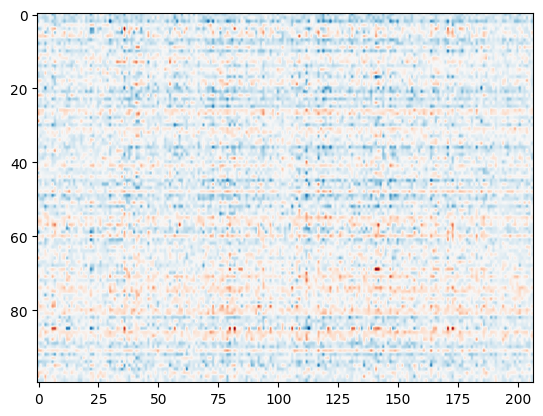

In [8]:
n_W = model.readout[0].weight.T
plt.imshow(n_W.detach().numpy(),interpolation=None, cmap='RdBu',aspect='auto')

In [9]:
trial_num = 0
for fold in range(N_FOLDS):
    datafile_pattern = config.datamodule.datafile_pattern.replace(".h5", f"_cv{fold}.h5")
    data_paths = sorted(glob(datafile_pattern))
    assert len(data_paths) == 1, 'Assumed a single dataset, got more'
    dataset_filename = data_paths[0] 
    sess_name='sess0' if fac_dim == 100 else ('go' if fold is None else f'cv{fold}') 

    with h5py.File(dataset_filename, 'r') as f:
        valid_inds = f["valid_inds"][:]
        valid_epoch = f["valid_epoch"][:]
        true_valid_beh = f['valid_vel'][:]
        valid_data = f['valid_recon_data'][:]

    assert np.all(np.diff(valid_epoch)>=0), 'Epochs are not sorted'
    assert [np.all(np.diff(valid_inds[valid_epoch==e]) > 0) for e in [0,1,2]], 'Indices are not sorted'

    trial_num+=len(valid_inds)

print(trial_num, true_valid_beh.shape, valid_data.shape)


581 (116, 101, 2) (116, 101, 207)


In [10]:
# create empty arrays for LFADS/BAND behavior predictions
concat_behaviors = [np.ones((trial_num,*true_valid_beh.shape[1:]))*np.nan for _ in range(2)] 
concat_noci_behaviors = [np.ones((trial_num,*true_valid_beh.shape[1:]))*np.nan for _ in range(2)] 
concat_true_behavior = np.ones((trial_num,*true_valid_beh.shape[1:]))*np.nan
concat_rates = [np.ones((trial_num,*valid_data.shape[1:]))*np.nan for _ in range(2)]
concat_noci_rates = [np.ones((trial_num,*valid_data.shape[1:]))*np.nan for _ in range(2)]
concat_data = np.ones((trial_num,*valid_data.shape[1:]))*np.nan
concat_factors = [np.ones((trial_num,valid_data.shape[1],fac_dim))*np.nan for _ in range(2)]
concat_factors_noci = [np.ones((trial_num,valid_data.shape[1],fac_dim))*np.nan for _ in range(2)]
concat_epochs = np.ones((trial_num,))*np.nan
concat_ids = np.ones((trial_num,))*np.nan
concat_target_direction = np.ones((trial_num,))*np.nan


for fold in range(N_FOLDS):
    datafile_pattern = config.datamodule.datafile_pattern.replace(".h5", f"_cv{fold}.h5")
    data_paths = sorted(glob(datafile_pattern))
    assert len(data_paths) == 1, 'Assumed a single dataset, got more'
    dataset_filename = data_paths[0] 
    sess_name='sess0' if fac_dim == 100 else ('go' if fold is None else f'cv{fold}') 

    with h5py.File(dataset_filename, 'r') as f:
        train_data = f['train_recon_data'][:]
        valid_data = f['valid_recon_data'][:]
        train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
        train_epoch = f["train_epoch"][:]
        valid_epoch = f["valid_epoch"][:]
        true_train_beh = f['train_vel'][:]
        true_valid_beh = f['valid_vel'][:]
        true_target_direction = f['valid_target_direction'][:]

    print(valid_inds[valid_epoch==0])

    true_pos = np.cumsum(true_valid_beh,axis=1) 

    def merge_train_valid(train_data, valid_data, train_inds, valid_inds):
        n_samples = len(train_data) + len(valid_data)
        merged_data = np.full((n_samples, *train_data.shape[1:]), np.nan)
        merged_data[train_inds] = train_data
        merged_data[valid_inds] = valid_data
        return merged_data

    for mi, model_name in enumerate(model_names):
        print(model_name)
        sess_name = f'cv{fold}'
        # data_path = os.path.join(model_dests[mi][fold],'best_model','',f'lfads_output_{sess_name}.h5')
        data_path = os.path.join(model_dests[mi][fold],f'lfads_output_{sess_name}.h5')
        bin_width_s = .01 # chewie
        # Data is binned at 10 ms
        with h5py.File(data_path) as f:
            print(f.keys())
            # Merge train and valid data for factors and rates
            train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
            factors = f["valid_factors"][:]
            rates = f["valid_output_params"][:] / bin_width_s
            behavior = f["valid_output_behavior_params"][:]
            controls = f['valid_gen_inputs'][:]
            ic = f['valid_gen_init'][:]
            control_mean = f['valid_co_means'][:]
            control_stds = f['valid_co_stds'][:]

            train_factors = f["train_factors"][:]
            train_controls = f['train_gen_inputs'][:]
            train_ic = f['train_gen_init'][:]
            train_rates = f["train_output_params"][:] / bin_width_s

        # load ablated model components
        data_path = os.path.join(model_dests[mi][fold],f'lfads_ablated_output_{sess_name}.h5')
        with h5py.File(data_path) as f:
            noci_factors = f["valid_factors"][:]
            noci_train_factors = f["train_factors"][:]
            noci_behavior = f["valid_output_behavior_params"][:]

            noci_rates = f["valid_output_params"][:] / bin_width_s
            noci_train_rates = f["train_output_params"][:] / bin_width_s
            # noci_controls = f['valid_gen_inputs'][:]

        # Ridge seq2seq
        X_train = train_factors.reshape(train_factors.shape[0],-1)
        Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
        X_test = factors.reshape(factors.shape[0],-1)
        ridge = Ridge(alpha=1).fit(X_train, Y_train)
        Y_pred_seq2seq = ridge.predict(X_test).reshape(true_valid_beh.shape)

        # Ridge seq2seq from noci factors
        X_train = noci_train_factors.reshape(noci_train_factors.shape[0],-1)
        Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
        X_test = noci_factors.reshape(noci_factors.shape[0],-1)
        ridge = Ridge(alpha=1).fit(X_train, Y_train)
        Y_pred_noci_seq2seq = ridge.predict(X_test).reshape(true_valid_beh.shape)

        # PCA on initial conditions
        pca = PCA(n_components=2)
        pca.fit(train_ic)
        ic_pca = pca.transform(ic)
        print(train_ic.shape,ic_pca.shape)

        concat_behaviors[mi][fold::N_FOLDS] = Y_pred_seq2seq
        concat_noci_behaviors[mi][fold::N_FOLDS] = Y_pred_noci_seq2seq
        concat_rates[mi][fold::N_FOLDS] = rates
        concat_noci_rates[mi][fold::N_FOLDS] = noci_rates
        concat_factors[mi][fold::N_FOLDS] = factors
        concat_factors_noci[mi][fold::N_FOLDS] = noci_factors
        if mi == 0:
            concat_data[fold::N_FOLDS] = valid_data
            concat_true_behavior[fold::N_FOLDS] = true_valid_beh
            concat_epochs[fold::N_FOLDS] = valid_epoch
            concat_ids[fold::N_FOLDS] = valid_inds
            concat_target_direction[fold::N_FOLDS] = true_target_direction
        else:
            assert np.all(concat_epochs[fold::N_FOLDS] == valid_epoch), 'Epochs do not match'
            assert np.all(concat_data[fold::N_FOLDS] == valid_data), 'Data does not match'
            assert np.all(concat_ids[fold::N_FOLDS] == valid_inds), 'Indices do not match'
            assert np.all(concat_target_direction[fold::N_FOLDS] == true_target_direction), 'Target directions do not match'
            assert np.all(concat_true_behavior[fold::N_FOLDS] == true_valid_beh), 'True behavior does not match'

[  1  10  18  25  30  38  43  52  57  62  67  72  77  84  92 103 109 114
 120 126 132 138 145 151 157 162 168 173 178 188 193 198 205 210]
lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci
<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_ic_mean', 'train_ic_std', 'train_inds', 'train_output_behavior_params', 'train_output_params', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_co_means', 'valid_co_stds', 'valid_con_states', 'valid_encod_data', 'valid_epoch', 'valid_factors', 'valid_gen_init', 'valid_gen_inputs', 'valid_gen_states', 'valid_ic_mean', 'valid_ic_std', 'valid_inds', 'valid_output_behavior_params', 'valid_output_params', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>
(464, 200) (117, 2)
band_both_100f_4c_kl1_gauss_bd_d20_causal_ci
<KeysViewHDF5 ['trai

(465, 200) (116, 2)
[  5  13  20  27  35  40  49  54  59  64  69  74  81  89  96 106 111 117
 122 129 134 140 147 153 159 165 170 175 183 190 195 200 207 212]
lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci
<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_ic_mean', 'train_ic_std', 'train_inds', 'train_output_behavior_params', 'train_output_params', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_co_means', 'valid_co_stds', 'valid_con_states', 'valid_encod_data', 'valid_epoch', 'valid_factors', 'valid_gen_init', 'valid_gen_inputs', 'valid_gen_states', 'valid_ic_mean', 'valid_ic_std', 'valid_inds', 'valid_output_behavior_params', 'valid_output_params', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>
(465, 200) (116, 2)
band_both_100f_4c_kl1_gauss_bd_d20_causal_ci


# Plot firing rate difference with/without controls

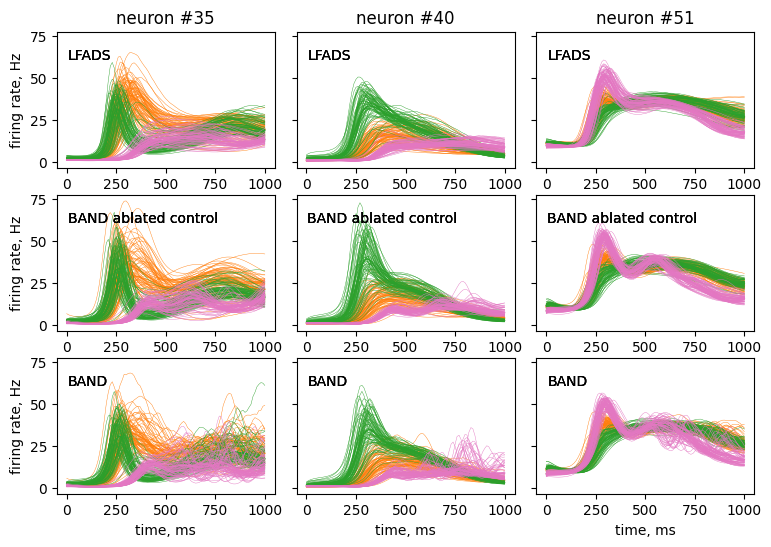

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(9, 6), sharey=True)

for k, (n, sub) in enumerate(zip([35, 40, 51], [[1, 2, 6], [1,2, 6], [1,2, 6]])):
    unique_dirs = np.unique(concat_target_direction)
    time = np.arange(rates.shape[1]) * 10

    for i, (frs, title) in enumerate(zip([concat_rates[0], concat_noci_rates[-1], concat_rates[-1]],
                                        ['LFADS', 'BAND ablated control', 'BAND'])):
        for j, d in enumerate(unique_dirs):
            if d in unique_dirs[sub]:
                mask = concat_target_direction == d
                axes[i, k].plot(
                    time,
                    frs[mask][..., n].mean(0),
                    linewidth=1,
                    c=f"C{j}",
                    label=d,
                )
                axes[i, k].plot(
                    time, frs[mask][..., n].T, linewidth=0.3, c=f"C{j}"
                )

                if i == 0:
                    axes[0, k].set_title(f"neuron #{n}")  # , firing rate")
                if k == 0:
                    axes[i, k].set_ylabel("firing rate, Hz")
                axes[i, k].set_xlabel("time, ms")
                axes[i, k].text(0.05, 0.8, title, transform=axes[i, k].transAxes, ha='left')
                # axes[i, k].set_ylim([0, 65])

# axes[0, 0].set_title("LFADS")
# axes[0, 1].set_title("Ctrl-TNDM")

# plt.legend(loc=(1.5, 0))
plt.subplots_adjust(wspace=0.1)

In [12]:
def get_target_ids(true_target_direction):
    ''' substitute direction elements with ids '''
    uniq_dirs = np.unique(true_target_direction)
    true_label = np.array([np.where(uniq_dirs==t)[0][0] for t in true_target_direction])
    return true_label

# widget to scroll through trials
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display

@widgets.interact
def plot_trial(trial_id=widgets.IntSlider(min=0, max=valid_data.shape[0]-1, step=1, value=0)):

    fig = plt.figure(figsize=(10, 4))

    # blank = fig.add_axes([0,0,1,1], frameon=True)

    axis_IC = fig.add_axes([0.05, 0.6, 0.1, 0.25])

    # PCA on initial conditions
    pca = PCA(n_components=2)
    pca.fit(train_ic)
    ic_pca = pca.transform(ic)
    # print(train_ic.shape,ic_pca.shape)

    axis_IC.set_title('Initial Conditions')
    axis_IC.scatter(*ic_pca.T,c=cm.rainbow(get_target_ids(true_target_direction)/8),s=2)
    axis_IC.scatter(*ic_pca[trial_id],c='k',
                    s=50,marker='*')
    axis_IC.scatter(*ic_pca[trial_id],c=cm.rainbow(get_target_ids(true_target_direction)/8)[trial_id],
                    s=20,marker='*')
    axis_IC.set_xlabel('PC1')
    axis_IC.set_ylabel('PC2')
    axis_IC.set_xticks([])
    axis_IC.set_yticks([])

    time = np.arange(controls.shape[1])*bin_size_ms
    axis_controls = fig.add_axes([0.05, 0.15, 0.25, 0.25])
    axis_controls.set_title('Controls')
    axis_controls.plot(time,controls[trial_id])
    axis_controls.set_xlabel('Time (ms)')
    axis_controls.set_ylabel('Control input')

    axis_factors = fig.add_axes([0.38, 0.6, 0.25, 0.25])
    axis_factors.set_title('Autonomous Factors')
    axis_factors.plot(time,(noci_factors[trial_id] - noci_factors[trial_id].mean(0))[:])
    axis_factors.set_xlabel('Time (ms)')
    axis_factors.set_ylabel('Factor')

    axis_noci_factors = fig.add_axes([0.38, 0.15, 0.25, 0.25])
    axis_noci_factors.set_title('Controlled Factors')
    axis_noci_factors.plot(time,(factors[trial_id] - factors[trial_id].mean(0))[:])
    axis_noci_factors.set_xlabel('Time (ms)')
    axis_noci_factors.set_ylabel('Factor')

    # draw an arrow from IC to autonomous factors

    axis_noci_behavior = fig.add_axes([0.71, 0.6, 0.25, 0.25])
    axis_behavior = fig.add_axes([0.71, 0.15, 0.25, 0.25])
    axis_noci_behavior.set_title('Behavior prediction from Autonomous')
    axis_behavior.set_title('Behavior prediction from Controlled')
    axis_noci_behavior.set_xlabel('Time (ms)')
    axis_noci_behavior.set_ylabel('Behavior')
    axis_behavior.set_xlabel('Time (ms)')
    axis_behavior.set_ylabel('Behavior')
    for i in [0,1]:
        axis_noci_behavior.plot(noci_behavior[trial_id][:,i],c=f'C{i}')
        axis_noci_behavior.plot(true_valid_beh[trial_id][:,i],linestyle=':',c=f'C{i}')
        axis_behavior.plot(behavior[trial_id][:,i],c=f'C{i}')
        axis_behavior.plot(true_valid_beh[trial_id][:,i],linestyle=':',c=f'C{i}')
    axis_noci_behavior.legend(['Predicted','True'])
    axis_behavior.legend(['Predicted','True'])

interactive(children=(IntSlider(value=0, description='trial_id', max=115), Output()), _dom_classes=('widget-in…

# Make sure that behavior is decodable from neural firing

In [13]:
from plot_helpers import get_random_trials2plot

def plot_beh_pred(vel, pred_vel, dir_index, t2p, axes, area, epoch_name, select = None, component=0,title=""):
    '''
    Plot hand velocity and predicted hand velocity for each direction
    '''
    BIN_SIZE = 10 # ms
    time = np.arange(vel.shape[1]) * BIN_SIZE

    for v, ls in zip([vel, pred_vel], ["--", "solid"]):
        for t in range(0, vel.shape[0]):
            if t2p[t]:
                d = dir_index[t]
                if select is None:
                    d_id = d
                else:
                    if d in select:
                        d_id = np.where(select == d)[0][0]
                    else: 
                        d_id = None
                if d_id is not None:
                    axes[d_id].plot(
                        time,
                        v[t, :, component],
                        color=f"C{d}",
                        alpha=1,
                        ls=ls,
                    )
    for d in range(len(axes)):
        axes[d].axvline(0,c='k')

    for ax in axes[:-1]:
        ax.axis("off")
    axes[-1].spines['top'].set_visible(False)
    axes[-1].spines['right'].set_visible(False)
    axes[-1].set_yticks([])
    axes[-1].set_xlabel("Time (ms)")
    component_names = ['Velocity X', 'Velocity Y']
    axes[-1].set_ylabel(component_names[component])
    axes[0].text(0,10,'Go Cue',rotation=90,va='top',ha='right')

    R2_iso_vel = r2_score(vel,pred_vel) #1 - np.sum((vel - pred_vel) ** 2) / np.sum((vel - vel.mean(0)) ** 2)
    if component == 0:
        r2 = r"$R^2$"
        axes[0].set_title(f'{title}: {r2} = {R2_iso_vel*100:.0f}%',loc='left')

np.random.seed(42)
dir_index = get_target_ids(concat_target_direction)
t2p = get_random_trials2plot(dir_index, concat_epochs.astype('int'), 1)

(0.0, 1.0, 0.0, 1.0)

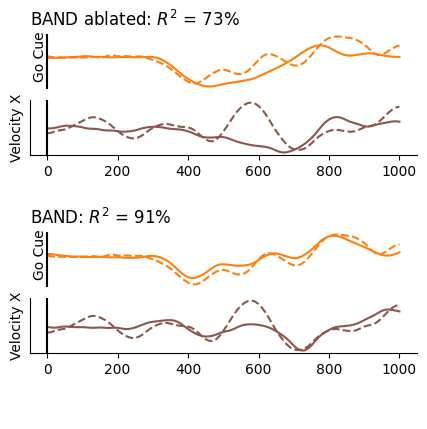

In [14]:
fig, axes = plt.subplots(6,1,figsize=(5,5))
select = [1,5]
plot_beh_pred(concat_true_behavior, concat_noci_behaviors[1], 
              dir_index, t2p, axes[:2], 
              'all', 'AD', select = select, component=0,title="BAND ablated")
axes[1].set_xlabel('')
axes[2].axis('off')
plot_beh_pred(concat_true_behavior, concat_behaviors[1],
              dir_index, t2p, axes[3:5], 
              'all', 'AD', select = select, component=0,title="BAND")
axes[4].set_xlabel('')
axes[5].axis('off')

# Make a print-ready figure

### calculate base LL

In [15]:
from scipy.stats import poisson
valid_mean_count = concat_data.mean(0).mean(0) # to get Hz -> x100
base_LL = poisson.logpmf(concat_data, valid_mean_count)
n_sp = concat_data.sum()

valid_LL = {'LFADS': poisson.logpmf(concat_data, (bin_size_ms / 1000) * concat_rates[0]), 
            'BAND': poisson.logpmf(concat_data, (bin_size_ms / 1000) * concat_rates[1]),
            'LFADS_noci': poisson.logpmf(concat_data, (bin_size_ms / 1000) * concat_noci_rates[0]), 
            'BAND_noci': poisson.logpmf(concat_data, (bin_size_ms / 1000) * concat_noci_rates[1])}
valid_co_bps = {key: np.sum(valid_LL[key] - base_LL)/(n_sp * np.log(2)) for key in valid_LL.keys()}
valid_co_bps

{'LFADS': 0.22614921000104296,
 'BAND': 0.22366563012563193,
 'LFADS_noci': 0.21817138947063364,
 'BAND_noci': 0.19455560806908934}

## calculate R2

In [57]:
beh_r2 = {key: 100*r2_score(concat_behaviors[i], concat_true_behavior) for i, key in enumerate(['LFADS','BAND'])}
beh_r2.update({key: 100*r2_score(concat_noci_behaviors[i], concat_true_behavior) for i, key in enumerate(['LFADS_noci','BAND_noci'])})
print(beh_r2)

{'LFADS': 81.28713854936387, 'BAND': 92.48292783397143, 'LFADS_noci': 78.62157694323312, 'BAND_noci': 76.89155513841874}


In [56]:
dir_index = get_target_ids(concat_target_direction)
beh_r2_uive = {key: 100*r2_UIVE(concat_behaviors[i], concat_true_behavior, dir_index) for i, key in enumerate(['LFADS','BAND'])}
beh_r2_uive.update({key: 100*r2_UIVE(concat_noci_behaviors[i], concat_true_behavior,dir_index) for i, key in enumerate(['LFADS_noci','BAND_noci'])})
print(beh_r2_uive)

{'LFADS': -22.48868435274118, 'BAND': 50.31306497735435, 'LFADS_noci': -39.9469276317868, 'BAND_noci': -51.269491742003105}


In [52]:
beh_mse = {key: np.mean((concat_behaviors[i] - concat_true_behavior)**2) for i, key in enumerate(['LFADS','BAND'])}
beh_mse.update({key: np.mean((concat_noci_behaviors[i] - concat_true_behavior)**2) for i, key in enumerate(['LFADS_noci','BAND_noci'])})

targets, preds = concat_true_behavior, concat_behaviors[1]
num_conditions = len(np.unique(dir_index))
avg_vel = np.zeros_like(targets)
for d in range(num_conditions):
    avg_vel[dir_index==d] = np.mean(targets[dir_index==d], axis=0)
beh_mse.update({'avg_behavior': np.mean((avg_vel - concat_true_behavior)**2)})
beh_mse.update({'var': np.mean((concat_true_behavior)**2)})

print(beh_mse)

{'LFADS': 12.63566242288024, 'BAND': 5.058520101139364, 'LFADS_noci': 14.41036223929471, 'BAND_noci': 15.543146933669547, 'avg_behavior': 10.47915716651682, 'var': 67.56513909836666}


### prepare factor in ordered trials

In [ ]:
factors_pull = concat_factors[1]
factors_noci_pull = concat_factors_noci[1]
ids_pull = concat_ids.copy()
epochs_pull = concat_epochs

ids_pull[epochs_pull == 1] = ids_pull[epochs_pull == 1] + 500
ids_pull[epochs_pull == 2] = ids_pull[epochs_pull == 2] + 1000

assert np.all(np.diff(ids_pull) > 0), 'IDs are not sorted'

fig, axes = plt.subplots(factors.shape[-1]//4,4, figsize=(10, 2*(factors.shape[-1]//4)))
for factor_id, ax in enumerate(axes.flatten()):
    fd = (factors_pull[:,:,factor_id]-factors_noci_pull[:,:,factor_id])
    ax.plot(fd.std(1), label='BAND')
    # gaussian filter
    from scipy.ndimage import gaussian_filter1d
    ax.plot(gaussian_filter1d(fd.std(1), 5))
    ax.axvline(np.sum(epochs_pull==0), color='k', linestyle='--')
    ax.axvline(np.sum(epochs_pull==1) + np.sum(epochs_pull==0), color='k', linestyle='--')
    n_BL = np.sum(epochs_pull==0)
    n_AD = np.sum(epochs_pull==1)
    n_WO = np.sum(epochs_pull==2)
    n = n_BL + n_AD + n_WO
    ax.axvline(n_BL, color='k', linestyle='--')
    ax.axvline(n_BL+n_AD, color='k', linestyle='--')
    ax.text(0.5 * n_BL / n, 0.8, 'BL', transform=ax.transAxes, ha='center')
    ax.text((n_BL + 0.5*n_AD) / n, 0.8, 'AD', transform=ax.transAxes, ha='center')
    ax.text((n_BL + n_AD + 0.5*n_WO) / n, 0.8, 'WO', transform=ax.transAxes, ha='center')
    ax.set_title(f'Factor {factor_id}')
    ax.set_ylabel('controlled variability')
    ax.set_xlabel('trial #')

plt.tight_layout()

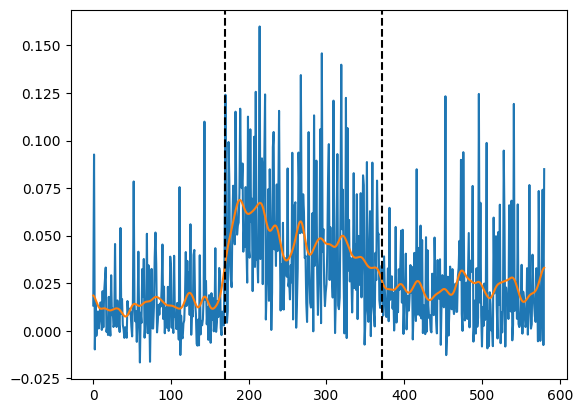

In [21]:
n_sp = concat_data.sum(1).sum(1)
data_pull = concat_data
base_LL_pull = poisson.logpmf(data_pull, data_pull.mean(0).mean(0))
cobps_pull = (poisson.logpmf(concat_data, (bin_size_ms / 1000) * concat_rates[1]) - base_LL_pull).sum(1).sum(1)/(n_sp * np.log(2)) 
cobps_noci_pull = (poisson.logpmf(concat_data,(bin_size_ms / 1000) * concat_noci_rates[1]) - base_LL_pull).sum(1).sum(1)/(n_sp * np.log(2))
plt.plot(cobps_pull- cobps_noci_pull)
# gaussian filter
from scipy.ndimage import gaussian_filter1d
plt.plot(gaussian_filter1d(cobps_pull - cobps_noci_pull, 5))
plt.axvline(np.sum(epochs_pull==0), color='k', linestyle='--')
plt.axvline(np.sum(epochs_pull==1) + np.sum(epochs_pull==0), color='k', linestyle='--')

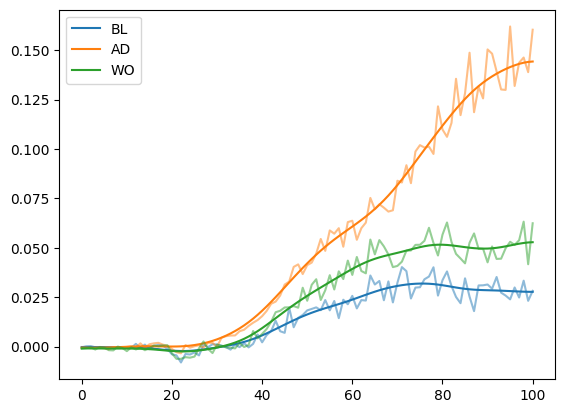

In [23]:
both_rates_pull = concat_rates[1]
both_noci_rates_pull = concat_noci_rates[1]

for e, epoch_name in enumerate(['BL','AD','WO']):
    n_sp = data_pull[epochs_pull==e].sum(0).sum(-1)
    cobps = poisson.logpmf(data_pull[epochs_pull==e], (bin_size_ms / 1000) * both_rates_pull[epochs_pull==e]).sum(0).sum(-1)/(n_sp * np.log(2)) 
    cobps_noci = poisson.logpmf(data_pull[epochs_pull==e], (bin_size_ms / 1000) * both_noci_rates_pull[epochs_pull==e]).sum(0).sum(-1)/(n_sp * np.log(2))
    plt.plot(cobps - cobps_noci,alpha=0.5,c=f"C{e}")
    # gaussian filter
    plt.plot(gaussian_filter1d(cobps - cobps_noci, 5),label=epoch_name,c=f"C{e}")
plt.legend()


(0.0, 100.0)

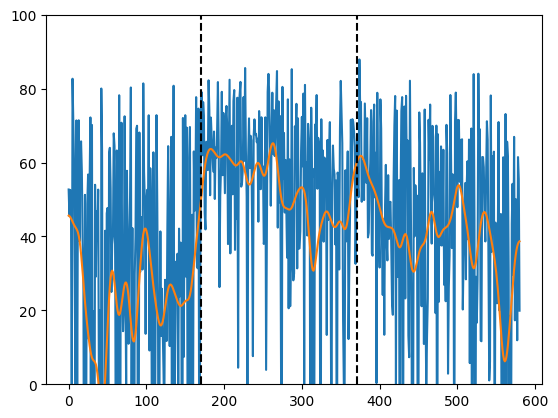

In [67]:
dir_index = get_target_ids(concat_target_direction)
num_conditions = len(np.unique(dir_index))

targets, preds = concat_true_behavior, concat_behaviors[1]
avg_vel = [np.mean(targets[dir_index==d], axis=0) for d in range(num_conditions)]
total_var = [((targets[dir_index==d] - avg_vel[d])**2).sum(1).sum(1) for d in range(num_conditions)]
expl_var  = [((preds[dir_index==d] - targets[dir_index==d])**2).sum(1).sum(1) for d in range(num_conditions)] 

r2_uive = np.ones(len(dir_index))*np.nan
for d in range(num_conditions):
    total_var[d][total_var[d]==0] = np.nan
    r2_uive[dir_index == d] = 100*(1 - expl_var[d] / total_var[d])

r2_uive_trials = r2_uive
plt.plot(r2_uive_trials)
# gaussian filter
from scipy.ndimage import gaussian_filter1d
plt.plot(gaussian_filter1d(r2_uive_trials, 5))
plt.axvline(np.sum(epochs_pull==0), color='k', linestyle='--')
plt.axvline(np.sum(epochs_pull==1) + np.sum(epochs_pull==0), color='k', linestyle='--')
plt.ylim([0.,100])

(0.0, 50.0)

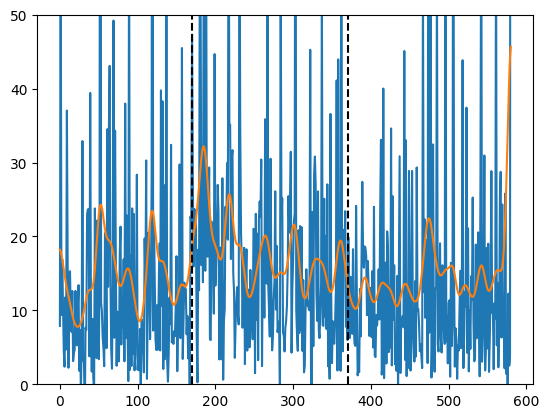

In [77]:
# mse_trials = np.mean((concat_behaviors[1] - concat_true_behavior)**2, axis=(1,2))
# plt.plot(mse_trials)

expl_var = np.mean((concat_behaviors[1] - concat_true_behavior)**2, axis=(1,2))
expl_var_noci = np.mean((concat_noci_behaviors[1] - concat_true_behavior)**2, axis=(1,2))
total_var = np.mean((concat_true_behavior)**2, axis=(1,2))
r2_trials = 100*(1 - expl_var / total_var) - 100*(1 - expl_var_noci / total_var)

plt.plot(r2_trials)

# gaussian filter
from scipy.ndimage import gaussian_filter1d
plt.plot(gaussian_filter1d(r2_trials, 5))
plt.axvline(np.sum(epochs_pull==0), color='k', linestyle='--')
plt.axvline(np.sum(epochs_pull==1) + np.sum(epochs_pull==0), color='k', linestyle='--')
plt.ylim([0,50])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


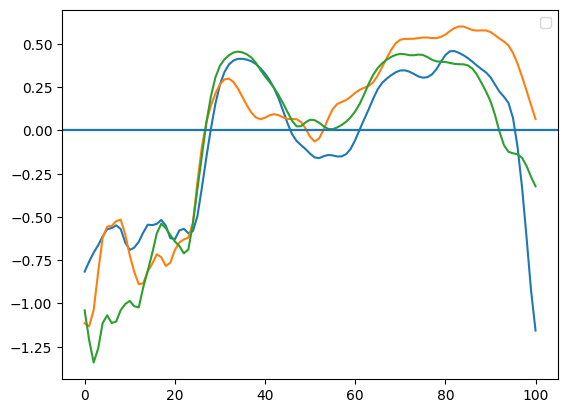

In [25]:
for e, epoch_name in enumerate(['BL','AD','WO']):
    targets, preds = concat_true_behavior[concat_epochs == e], concat_behaviors[1][concat_epochs==e]
    dir_idx = get_target_ids(concat_target_direction[concat_epochs == e])
    avg_vel = [np.mean(targets[dir_idx==d], axis=0) for d in range(num_conditions)]
    total_var = [((targets[dir_idx==d] - avg_vel[d])**2).sum(0).sum(-1) for d in range(num_conditions)]
    expl_var  = [((preds[dir_idx==d] - targets[dir_idx==d])**2).sum(0).sum(-1) for d in range(num_conditions)] 

    for d in range(num_conditions):
        total_var[d][total_var[d]==0] = np.nan
    r2_uive = np.array([1 - expl_var[d] / total_var[d] for d in range(num_conditions)]).mean(0)
    plt.plot(r2_uive,c=f"C{e}")
    plt.axhline(0)
    # gaussian filter
    # plt.plot(gaussian_filter1d(mse, 5),label=epoch_name,c=f"C{e}")
plt.legend()


### then plot the figure

In [26]:
from goodman_panels import panels, panel_specs, label_panel, label_panels

In [27]:
def make_task_schematics(ax, x,y,r,aspect=1.,shown=np.ones(8)):

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # bbox = ax.get_window_extent().transformed(ax.get_figure().dpi_scale_trans.inverted())
    # aspect = bbox.width / bbox.height
    # print(aspect)

    # draw a circle around the center with 8 target directions
    theta = np.roll(np.linspace(0,2*np.pi,9)[:-1],3)
    x_t = x + r*np.cos(theta)
    y_t = y + r*np.sin(theta)*aspect

    for c, (s, xt, yt) in enumerate(zip(shown, x_t,y_t)):
        fill = {'facecolors': f'C{c}'} if s else {'facecolors': 'none'}
        ax.scatter(xlim[0] + (xlim[1] - xlim[0])*xt,
                    ylim[0] + (ylim[1] - ylim[0])*yt,
                    s=20,edgecolors=f'C{c}',linewidth=.5,
                    **fill)
    ax.scatter(xlim[0] + (xlim[1] - xlim[0]) * x,
                ylim[0] + (ylim[1] - ylim[0]) * y,
                s = 20, c='k', marker='+',linewidth=.5)

/tmp/ipykernel_689038/3416870211.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes['C0'].set_xticklabels(axes['C0'].get_xticklabels(), rotation=90)
/tmp/ipykernel_689038/3416870211.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes['D0'].set_xticklabels(axes['D0'].get_xticklabels(), rotation=90)
/tmp/ipykernel_689038/3416870211.py:187: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes['E0'].set_xticklabels(axes['E0'].get_xticklabels(), rotation=90)


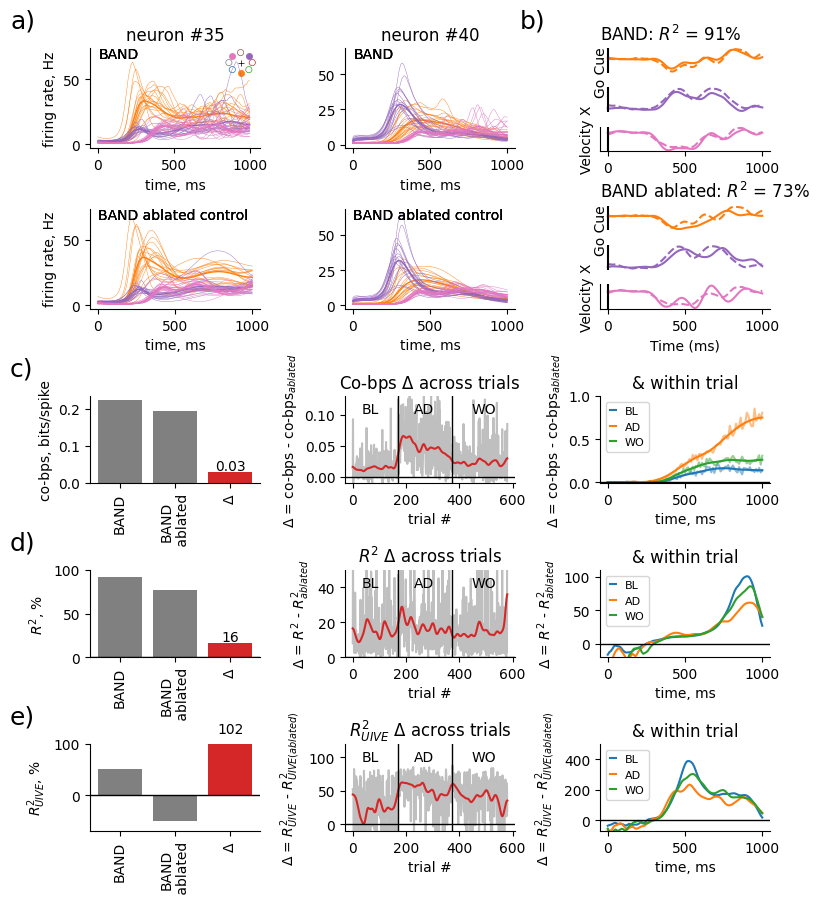

In [80]:
layout = '''
AAB
AAB
CCC
DDD
EEE
'''
fig = plt.figure(figsize=(8, 9))
# blank = fig.add_subplot([0,0,1,1])
specs, gs = panel_specs(layout, fig=fig, gridspec_args={'left': 0.1, 'right': .95, 'bottom': 0.08, 'top': 0.95, 'hspace': 1., 'wspace': .5})
axes = {}

gs.set_width_ratios([1,1,1])
gs.set_height_ratios([1,1,1,1,1])

subgs = specs['A'].subgridspec(2, 2, wspace=0.5)
for j in range(2):
    for i in range(2):
        if j == 0:
            axes[f"A{j}{i}"] = ax = fig.add_subplot(subgs[j,i])
        else:
            axes[f'A{j}{i}'] = ax = fig.add_subplot(subgs[j,i], sharey=axes[f'A0{i}'])
label_panel(axes['A00'], 'a', postfix=')')

subgs = specs['B'].subgridspec(2*3+1, 1, wspace=0.1)
for j in range(2*3+1):
    axes[f"B{j}"] = ax = fig.add_subplot(subgs[j])
label_panel(axes['B0'], 'b', postfix=')')

subgs = specs['C'].subgridspec(1, 3, wspace=0.5)
subgs.set_width_ratios([1, 1, 1])
for i in range(3):
    axes[f"C{i}"] = ax = fig.add_subplot(subgs[i])
label_panel(axes['C0'], 'c', postfix=')')

subgs = specs['D'].subgridspec(1, 3, wspace=0.5)
subgs.set_width_ratios([1, 1, 1])
for i in range(3):
    axes[f"D{i}"] = ax = fig.add_subplot(subgs[i])
label_panel(axes['D0'], 'd', postfix=')')

subgs = specs['E'].subgridspec(1, 3, wspace=0.5)
subgs.set_width_ratios([1, 1, 1])
for i in range(3):
    axes[f"E{i}"] = ax = fig.add_subplot(subgs[i])
label_panel(axes['E0'], 'e', postfix=')')

trial_kernel_w = 7 # kernel width for smoothing over trials

select = [1,4,6] # directions to plot
for k, (n, sub) in enumerate(zip([35, 40], [select,select,select])):
    unique_dirs = np.unique(concat_target_direction)
    time = np.arange(rates.shape[1]) * 10

    for i, (frs, title) in enumerate(zip([concat_rates[1], concat_noci_rates[1]],
                                        ['BAND', 'BAND ablated control'])):
        for j, d in enumerate(unique_dirs):
            if d in unique_dirs[sub]:
                mask = concat_target_direction == d
                axes[f'A{i}{k}'].plot(
                    time,
                    frs[mask][..., n].mean(0),
                    linewidth=1,
                    c=f"C{j}",
                    label=d,
                )
                axes[f'A{i}{k}'].plot(
                    time, frs[mask][::4,..., n].T, linewidth=0.3, c=f"C{j}"
                )

                if i == 0:
                    axes[f'A0{k}'].set_title(f"neuron #{n}")  # , firing rate")
                if k == 0:
                    axes[f'A{i}{k}'].set_ylabel("firing rate, Hz")
                axes[f'A{i}{k}'].set_xlabel("time, ms")
                axes[f'A{i}{k}'].text(0.05, 0.9, title, transform=axes[f'A{i}{k}'].transAxes, ha='left')
one_hot_select = [1 if s in select else 0 for s in range(8)]                
make_task_schematics(axes['A00'], 0.9,0.9,0.07,aspect=1.5,shown=one_hot_select)

# panel C
plot_beh_pred(concat_true_behavior, concat_behaviors[1], 
              dir_index, t2p, [axes[f'B{i}'] for i in range(3)], 
              'all', 'AD', select = select, component=0,title="BAND")
axes['B2'].set_xlabel('')
axes['B3'].axis('off')
plot_beh_pred(concat_true_behavior, concat_noci_behaviors[1], 
              dir_index, t2p, [axes[f'B{i}'] for i in range(4,7)], 
              'all', 'AD', select = select, component=0,title="BAND ablated")

for k in axes.keys():
    axes[k].spines['right'].set_visible(False)
    axes[k].spines['top'].set_visible(False)

# Panel A: plot oscillating factor variability
axes['C0'].bar(['BAND', 'BAND\n ablated', r'$\Delta$'], 
               [valid_co_bps['BAND'], valid_co_bps['BAND_noci'], 
                valid_co_bps['BAND'] - valid_co_bps['BAND_noci']],
               color=['grey','grey','C3'])
axes['C0'].set_xticklabels(axes['C0'].get_xticklabels(), rotation=90)
axes['C0'].set_ylabel('co-bps, bits/spike')
axes['C0'].text(2, (valid_co_bps['BAND'] - valid_co_bps['BAND_noci'])*1.2,
                f"{valid_co_bps['BAND'] - valid_co_bps['BAND_noci']:.2f}", ha='center')

axes['C1'].plot(cobps_pull- cobps_noci_pull,alpha=0.5,c='grey')
axes['C1'].plot(gaussian_filter1d(cobps_pull - cobps_noci_pull, trial_kernel_w),c='C3')
n_BL = np.sum(epochs_pull==0)
n_AD = np.sum(epochs_pull==1)
n_WO = np.sum(epochs_pull==2)
n = n_BL + n_AD + n_WO
axes['C1'].axvline(n_BL, color='k', linewidth=1)
axes['C1'].axvline(n_BL+n_AD, color='k', linewidth=1)
axes['C1'].axhline(0, color='k', linewidth=1)
axes['C1'].text(0.5 * n_BL / n, 0.8, 'BL', transform=axes['C1'].transAxes, ha='center')
axes['C1'].text((n_BL + 0.5*n_AD) / n, 0.8, 'AD', transform=axes['C1'].transAxes, ha='center')
axes['C1'].text((n_BL + n_AD + 0.5*n_WO) / n, 0.8, 'WO', transform=axes['C1'].transAxes, ha='center')
axes['C1'].set_xlabel('trial #')
axes['C1'].set_ylabel(r'$\Delta$ = co-bps - co-bps$_{ablated}$')
axes['C1'].set_title(r'Co-bps $\Delta$ across trials')
# axes['C1'].set_yticks([0,0.05])
axes['C1'].set_ylim([-0.01,0.13])

axes['C2'].set_title('& within trial')
time = np.arange(concat_data.shape[1])*bin_size_ms
for e, epoch_name in enumerate(['BL','AD','WO']):
    n_sp = valid_data[valid_epoch==e].sum(0).sum(-1)
    cobps = poisson.logpmf(data_pull[epochs_pull==e], (bin_size_ms / 1000) * both_rates_pull[epochs_pull==e]).sum(0).sum(-1)/(n_sp * np.log(2)) 
    cobps_noci = poisson.logpmf(data_pull[epochs_pull==e], (bin_size_ms / 1000) * both_noci_rates_pull[epochs_pull==e]).sum(0).sum(-1)/(n_sp * np.log(2))
    axes['C2'].plot(time, cobps - cobps_noci,alpha=0.5,c=f"C{e}")
    # gaussian filter
    axes['C2'].plot(time, gaussian_filter1d(cobps - cobps_noci, 5),label=epoch_name,c=f"C{e}")
axes['C2'].legend(loc='upper left',handlelength=.5,fontsize=8)
axes['C2'].set_xlabel('time, ms')
axes['C2'].set_ylabel(r'$\Delta$ = co-bps - co-bps$_{ablated}$')
# axes['C2'].set_yticks([0,0.05])
axes['C2'].axhline(0, color='k', linewidth=1)
axes['C2'].set_ylim([-0.01,1.0])

# Panel A: plot oscillating factor variability
delta = beh_r2['BAND'] - beh_r2['BAND_noci']
axes['D0'].bar(['BAND', 'BAND\n ablated', r'$\Delta$'], 
               [beh_r2['BAND'], beh_r2['BAND_noci'],
                delta],
                color=['grey','grey','C3'])
axes['D0'].set_xticklabels(axes['D0'].get_xticklabels(), rotation=90)
axes['D0'].set_ylabel(r'$R^2$, %')
axes['D0'].text(2, 1.2*delta,
                f"{delta:.0f}", ha='center')
axes['D0'].set_ylim([0,100])
axes['D0'].axhline(0, color='k', linewidth=1)

axes['D1'].plot(r2_trials,alpha=0.5,c='grey')
axes['D1'].plot(gaussian_filter1d(r2_trials, trial_kernel_w),c='C3')
n_BL = np.sum(epochs_pull==0)
n_AD = np.sum(epochs_pull==1)
n_WO = np.sum(epochs_pull==2)
n = n_BL + n_AD + n_WO
axes['D1'].axvline(n_BL, color='k', linewidth=1)
axes['D1'].axvline(n_BL+n_AD, color='k', linewidth=1)
axes['D1'].axhline(0, color='k', linewidth=1)
axes['D1'].text(0.5 * n_BL / n, 0.8, 'BL', transform=axes['D1'].transAxes, ha='center')
axes['D1'].text((n_BL + 0.5*n_AD) / n, 0.8, 'AD', transform=axes['D1'].transAxes, ha='center')
axes['D1'].text((n_BL + n_AD + 0.5*n_WO) / n, 0.8, 'WO', transform=axes['D1'].transAxes, ha='center')
axes['D1'].set_xlabel('trial #')
axes['D1'].set_ylabel(r'$\Delta$ = $R^2$ - $R^2_{ablated}$')
axes['D1'].set_title(r'$R^2$ $\Delta$ across trials')
axes['D1'].set_ylim([0,50])

axes['D2'].set_title('& within trial')
time = np.arange(concat_data.shape[1])*bin_size_ms
for e, epoch_name in enumerate(['BL','AD','WO']):
    mse_BAND = np.mean((concat_behaviors[1][concat_epochs == e] - concat_true_behavior[concat_epochs == e])**2, axis=(0,2))
    mse_BAND_noci = np.mean((concat_noci_behaviors[1][concat_epochs == e] - concat_true_behavior[concat_epochs == e])**2, axis=(0,2))
    total_var = np.mean((concat_true_behavior[concat_epochs == e])**2, axis=(0,2))
    axes['D2'].plot(time,100*(mse_BAND_noci - mse_BAND)/total_var,label=epoch_name,c=f"C{e}")
axes['D2'].legend(loc='upper left',handlelength=.5,fontsize=8)
axes['D2'].set_xlabel('time, ms')
axes['D2'].set_ylabel(r'$\Delta$ = $R^2$ - $R^2_{ablated}$')
axes['D2'].axhline(0, color='k', linewidth=1)
axes['D2'].set_ylim([-20,110])

# Panel A: plot oscillating factor variability
delta = beh_r2_uive['BAND'] - beh_r2_uive['BAND_noci']
axes['E0'].bar(['BAND', 'BAND\n ablated', r'$\Delta$'], 
               [beh_r2_uive['BAND'], beh_r2_uive['BAND_noci'],
                delta],
                color=['grey','grey','C3'])
axes['E0'].set_xticklabels(axes['E0'].get_xticklabels(), rotation=90)
axes['E0'].set_ylabel(r'$R^2_{UIVE}$, %')
axes['E0'].text(2, 1.2*delta,
                f"{delta:.0f}", ha='center')
axes['E0'].set_ylim([-70,100])
axes['E0'].axhline(0, color='k', linewidth=1)

axes['E1'].plot(r2_uive_trials,alpha=0.5,c='grey')
axes['E1'].plot(gaussian_filter1d(r2_uive_trials, trial_kernel_w),c='C3')
n_BL = np.sum(epochs_pull==0)
n_AD = np.sum(epochs_pull==1)
n_WO = np.sum(epochs_pull==2)
n = n_BL + n_AD + n_WO
axes['E1'].axvline(n_BL, color='k', linewidth=1)
axes['E1'].axvline(n_BL+n_AD, color='k', linewidth=1)
axes['E1'].axhline(0, color='k', linewidth=1)
axes['E1'].text(0.5 * n_BL / n, 0.8, 'BL', transform=axes['E1'].transAxes, ha='center')
axes['E1'].text((n_BL + 0.5*n_AD) / n, 0.8, 'AD', transform=axes['E1'].transAxes, ha='center')
axes['E1'].text((n_BL + n_AD + 0.5*n_WO) / n, 0.8, 'WO', transform=axes['E1'].transAxes, ha='center')
axes['E1'].set_xlabel('trial #')
axes['E1'].set_ylabel(r'$\Delta$ = $R^2_{UIVE}$ - $R^2_{UIVE(ablated)}$')
axes['E1'].set_title(r'$R^2_{UIVE}$ $\Delta$ across trials')
axes['E1'].set_ylim([-10,120])

axes['E2'].set_title('& within trial')
time = np.arange(concat_data.shape[1])*bin_size_ms
for e, epoch_name in enumerate(['BL','AD','WO']):
    targets, preds, noci_preds = concat_true_behavior[concat_epochs == e], concat_behaviors[1][concat_epochs==e], concat_noci_behaviors[1][concat_epochs==e]
    dir_idx = get_target_ids(concat_target_direction[concat_epochs == e])
    avg_vel = [np.mean(targets[dir_idx==d], axis=0) for d in range(num_conditions)]
    total_var = [((targets[dir_idx==d] - avg_vel[d])**2).sum(0).sum(-1) for d in range(num_conditions)]
    expl_var  = [((preds[dir_idx==d] - targets[dir_idx==d])**2).sum(0).sum(-1) for d in range(num_conditions)] 
    expl_var_noci  = [((noci_preds[dir_idx==d] - targets[dir_idx==d])**2).sum(0).sum(-1) for d in range(num_conditions)] 

    for d in range(num_conditions):
        total_var[d][total_var[d]==0] = np.nan
    r2_uive_BAND = np.array([1 - expl_var[d] / total_var[d] for d in range(num_conditions)]).mean(0)
    r2_uive_BAND_noci = np.array([1 - expl_var_noci[d] / total_var[d] for d in range(num_conditions)]).mean(0)
    axes['E2'].plot(time,100*(r2_uive_BAND - r2_uive_BAND_noci),label=epoch_name,c=f"C{e}")
axes['E2'].legend(loc='upper left',handlelength=.5,fontsize=8)
axes['E2'].set_xlabel('time, ms')
axes['E2'].set_ylabel(r'$\Delta$ = $R^2_{UIVE}$ - $R^2_{UIVE(ablated)}$')
# axes['C2'].set_yticks([0,0.05])
axes['E2'].axhline(0, color='k', linewidth=1)
axes['E2'].set_ylim([-70,500])

plt.subplots_adjust(hspace=0.6)
# plt.tight_layout()
plt.savefig(f"figs/fig5_{dataset_name}_{model_name}.pdf")
plt.savefig(f"figs/fig5_{dataset_name}_{model_name}.png")